In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import seaborn as sns
import anndata as ad

In [2]:
os.makedirs('../../results/04_spatial/15_integrate_with_cell_proportion', exist_ok=True)

In [3]:
sample_list = ['HC01', 'HC02', 'HC03', 'HC05',
               #'SSc4733', 
               'SSc4994', 'SSc5380', 
               #'SSc5722',
               'SSc-HL01', 'SSc-HL05', 'SSc-HL06', 'SSc-HL11',
               'SSc-HL13', 'SSc-HL25', 'SSc-HL33', 'SSc-HL35']

In [4]:
adata_cts = []

for sample in sample_list:
    adata = sc.read_h5ad(f'../../results/04_spatial/09_run_cell2location/{sample}.h5ad')
    df = adata.obsm['q05_cell_abundance_w_sf']
    df = df.div(df.sum(axis=1), axis=0)
    df.columns = adata.uns['mod']['factor_names']
    
    adata_ct = sc.AnnData(df)
    adata_ct.obs['patient_id'] = sample
    adata_ct.obs['condition'] = 'Healthy' if sample in ['HC01', 'HC02', 'HC03', 'HC05'] else 'SSc'
    
    adata_cts.append(adata_ct)

In [5]:
adata = ad.concat(adata_cts)
sc.pp.neighbors(adata, n_neighbors=30)
sc.tl.umap(adata)

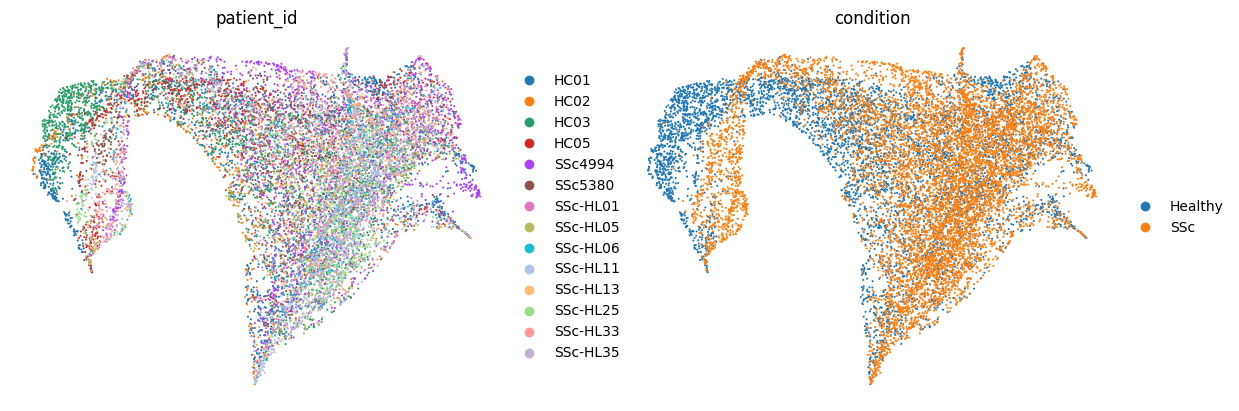

In [6]:
sc.pl.umap(adata, color=['patient_id', 'condition'], frameon=False)

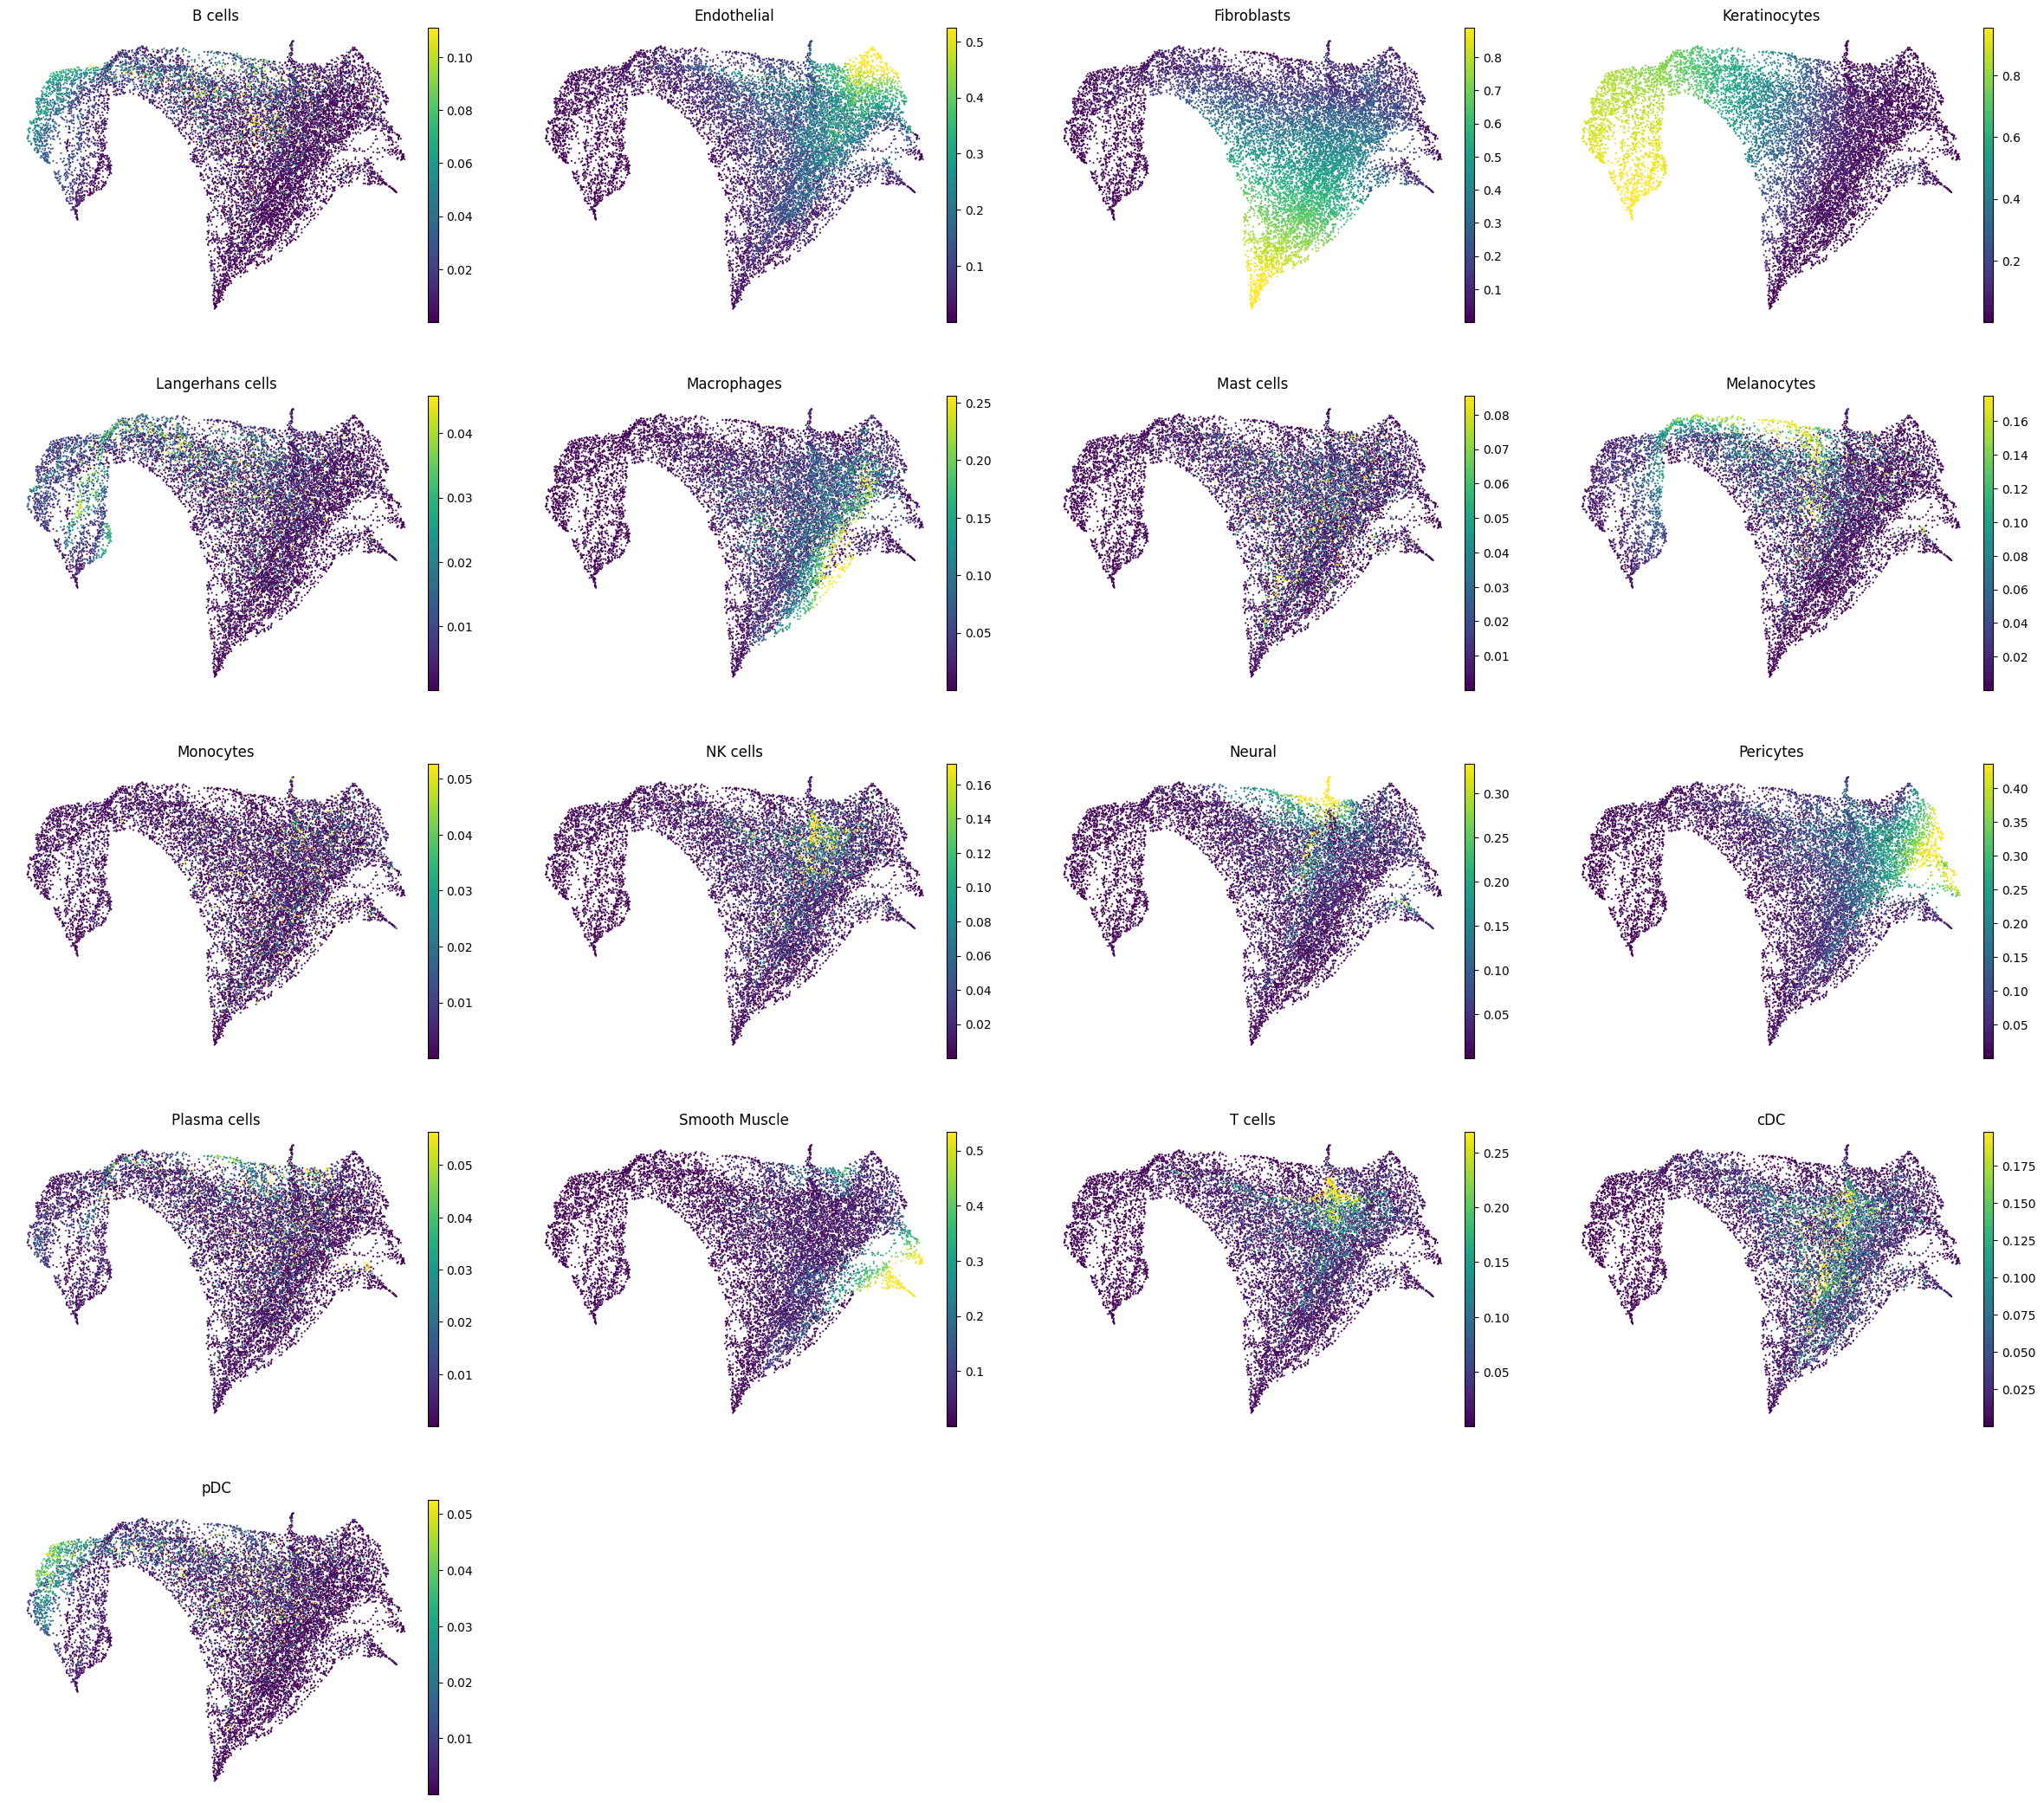

In [7]:
sc.pl.umap(adata, color=adata.var_names, frameon=False, vmax='p99', vmin='p1')

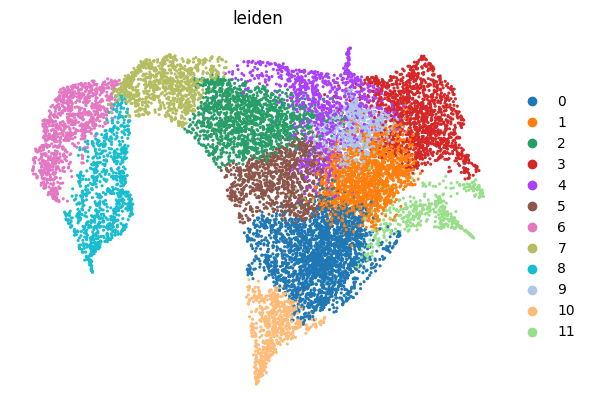

In [8]:
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'], frameon=False, size=20)

In [9]:
adata.var_names

Index(['B cells', 'Endothelial', 'Fibroblasts', 'Keratinocytes',
       'Langerhans cells', 'Macrophages', 'Mast cells', 'Melanocytes',
       'Monocytes', 'NK cells', 'Neural', 'Pericytes', 'Plasma cells',
       'Smooth Muscle', 'T cells', 'cDC', 'pDC'],
      dtype='object')

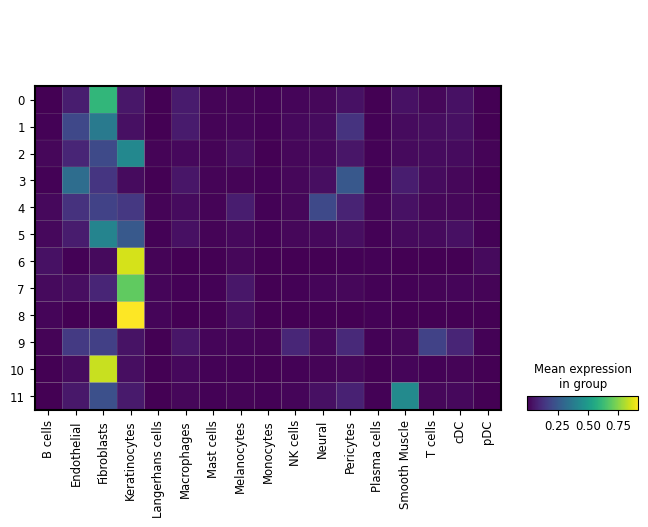

In [10]:
sc.pl.matrixplot(adata, var_names=adata.var_names, 
                 groupby='leiden', dendrogram=False, 
                 #standard_scale='var'
                )

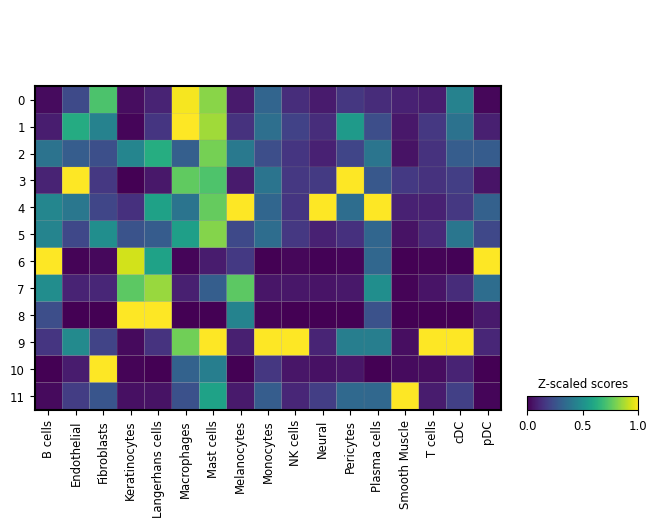

In [11]:
sc.pl.matrixplot(adata, var_names=adata.var_names, 
                 groupby='leiden', dendrogram=False, 
                 standard_scale='var',
                 colorbar_title='Z-scaled scores')

In [12]:
# get average values
grouped = adata.obs.groupby('leiden')

df = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

for group, idx in grouped.indices.items():
    X = adata.X[idx]
    df[group] = np.ravel(X.mean(axis=0, dtype=np.float64))

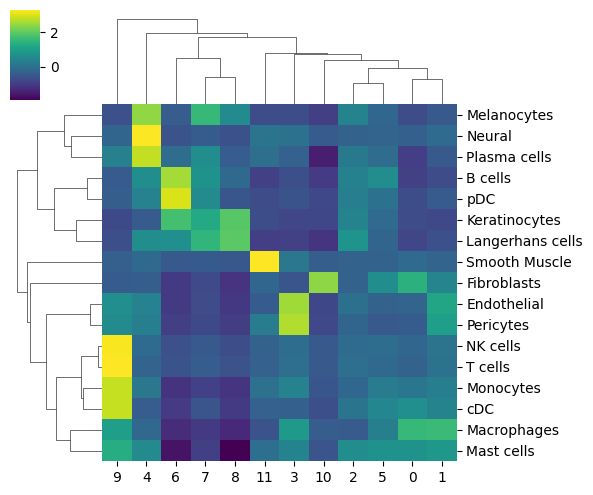

In [13]:
normalized_df = df.apply(lambda x: (x - np.mean(x)) / np.std(x), axis=1)

sns.clustermap(normalized_df, cmap='viridis', figsize=(6, 5))

In [15]:
normalized_df.to_csv('../../results/04_spatial/15_integrate_with_cell_proportion/cell_type_proportion_in_spatial_niche.csv')
adata.write_h5ad('../../results/04_spatial/15_integrate_with_cell_proportion/integrated.h5ad')

In [18]:
adata.obs['barcode'] = adata.obs.index.values.tolist()

In [19]:
adata.obs

patient_id condition leiden             barcode
AACACTTGGCAAGGAA-1       HC01   Healthy      3  AACACTTGGCAAGGAA-1
AACAGGATTCATAGTT-1       HC01   Healthy      2  AACAGGATTCATAGTT-1
AACAGGTTATTGCACC-1       HC01   Healthy     11  AACAGGTTATTGCACC-1
AACAGGTTCACCGAAG-1       HC01   Healthy      7  AACAGGTTCACCGAAG-1
AACATCTAATGACCGG-1       HC01   Healthy      6  AACATCTAATGACCGG-1
...                       ...       ...    ...                 ...
TGTTCAGAACGGTGTA-1   SSc-HL35       SSc      1  TGTTCAGAACGGTGTA-1
TGTTCATAGTATGACG-1   SSc-HL35       SSc      4  TGTTCATAGTATGACG-1
TGTTCTGCTCTGTCGT-1   SSc-HL35       SSc      0  TGTTCTGCTCTGTCGT-1
TGTTGGAACGAGGTCA-1   SSc-HL35       SSc      5  TGTTGGAACGAGGTCA-1
TGTTGGCCAGACCTAC-1   SSc-HL35       SSc      0  TGTTGGCCAGACCTAC-1

[13204 rows x 4 columns]

In [20]:
adata.obs.to_csv("../../results/04_spatial/15_integrate_with_cell_proportion/niches.csv", index=False)

In [2]:
adata = sc.read_h5ad('../../results/04_spatial/15_integrate_with_cell_proportion/integrated.h5ad')

In [3]:
# get average values
grouped = adata.obs.groupby('leiden')

df = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

for group, idx in grouped.indices.items():
    X = adata.X[idx]
    df[group] = np.ravel(X.mean(axis=0, dtype=np.float64))

In [4]:
df1 = df.div(df.sum(axis=1), axis=0)

In [5]:
df1.to_csv("../../results/04_spatial/15_integrate_with_cell_proportion/cell_type_prop_in_niches.csv", index=True)

In [6]:
df2 = df.div(df.sum(axis=0), axis=1)

In [9]:
df2.to_csv("../../results/04_spatial/15_integrate_with_cell_proportion/cell_type_prop_in_niches_v2.csv", index=True)